# Enhancing AI Agent Tool-Calling Accuracy Through Fine-Tuning

![Title Diagram](./img/intro2.png)



---

This notebook accompanies the conference demo and serves as a structured cookbook for reproducing the full workflow.

### Demo Goal: Improving the Zava Retail Agent

To make this notebook concrete, we use a fictional retail brand called **Zava**, which provides a customer-service AI agent powered by **Microsoft Foundry** and a **Retail MCP Server** exposing 17 tools (product search, user lookup, order details, returns, exchanges, profile updates, and more).

The goal of this demo is to show how to improve the Zava agent’s **tool-calling accuracy and multi-turn reliability** using modern fine-tuning techniques.

---

#### Simple Cases Work

We begin by showing that the base model (e.g., `gpt-4.1-mini`) handles **simple tool calls** correctly.  
For example, a request like:

> “Can you show me all your products?”

is resolved with the correct MCP tool invocation and produces the expected result.

This establishes the baseline:  
**single-tool operations generally work out of the box.**

---

#### Where the Base Model Breaks

More complex customer scenarios — such as updating an address, processing returns, or combining multiple tool steps — require the model to:

- chain tool outputs correctly  
- pass parameters from one tool call to the next  
- remain consistent across many turns  

This is where the base model struggles, motivating the need for fine-tuning.

---

#### What This Demo Will Show

The remainder of this notebook demonstrates how to improve the Zava agent through:

1. **Synthetic Data Generation**  
   Creating high-quality multi-turn retail conversations using the new generation capabilities in Microsoft Foundry.

2. **Supervised Fine-Tuning (SFT)**  
   Teaching the model correct tool invocation patterns and policy-aligned reasoning.

3. **Evaluation with Python Graders**  
   Measuring tool-calling accuracy and verifying parameter correctness.

4. **Reinforcement Fine-Tuning (RFT)**  
   Optimizing the model for even more complex workflows using grader-based reward signals.

---

#### Notebook Roadmap

This notebook is structured to follow the same path as the demo:

1. Architecture overview (Agent + MCP Server)  
2. Environment setup  
3. Baseline behavior  
4. Evaluation methodology  
5. Synthetic data  
6. SFT  
7. RFT  
8. Results and comparisons  

Together, these steps show how to transform the Zava agent into a **reliable, policy-aligned, multi-turn tool-calling system**.


## 1. Architecture: Retail Agent + MCP Server + Tooling

This section provides a high-level overview of the Zava retail agent’s architecture.  
Understanding how the components interact helps motivate why fine-tuning is needed and which behaviors we expect to improve.

---

### 1.1 Zava Retail Agent (Microsoft Foundry Agent Service)

The Zava agent is built using the **Microsoft Foundry Agent Service**, which acts as an orchestrator:

- Interprets customer intent  
- Selects the appropriate tool  
- Constructs structured tool-call arguments  
- Incorporates chain-of-thought reasoning  
- Produces a final, customer-friendly response  

The agent is configured with:

- **A system prompt** describing Zava’s retail rules and policies  
- **Structured tool definitions** (17 MCP tools)  
- **A deployed model** such as:
  - `gpt-4.1`
  - `gpt-4.1-mini`
  - `gpt-4.1-nano`
  - Later in this notebook: fine-tuned variants  

The agent is the “brain” of the system—driving all reasoning and tool decisions.

---

### 1.2 Retail MCP Server (Tool Provider)

The agent relies on a dedicated **Model Context Protocol (MCP) server**, hosted at:

```
https://retail-mcp-server-sim.braveflower-06b407cc.eastus.azurecontainerapps.io/
```

The MCP server exposes **9 tools** representing Zava’s operational backend:

```
User Lookup
 ├─ find_user_id_by_email
 ├─ find_user_id_by_name_zip
 └─ get_user_details

Orders
 ├─ get_order_details
 ├─ cancel_pending_order
 └─ exchange_delivered_order_items

Products
 ├─ list_products
 └─ get_product_details

Customer Profile
 └─ update_address
```

Each tool includes:

- A schema for inputs (e.g., `user_id`, `order_id`, `zip`)  
- A schema for outputs (user profile, order details, product metadata)  
- Built-in policy constraints (e.g., return windows per product category)  

These tools form the **action space** available to the LLM.

---

### 1.3 Interaction Interfaces (UI + CLI)

Two interfaces are used throughout this notebook and demo.

#### **Microsoft Foundry Playground (UI)**  
Best for:
- Visualizing tool calls in real time  
- Demonstrating simple workflows  
- Introducing the agent architecture  
- Zero configuration required  

#### **Local `retail_agent` CLI (included with this cookbook)**  
Best for:
- Rapid multi-turn iteration  
- Testing fine-tuned models side-by-side  
- Replaying complex customer scenarios  
- Inspecting raw traces, JSON tool responses, and argument passing  

Using both interfaces gives a complete view of the agent’s behavior—both polished and low-level.

---

### 1.4 End-to-End Request Flow

Below is a conceptual diagram of the Zava agent workflow:

```
Customer Message
       │
       ▼
[ Agent (LLM + Policies + Tool Schemas) ]
       │
       │  Determines next action
       ▼
[ MCP Server ]
       │
       │  Executes structured tool call
       ▼
Tool Output (JSON)
       │
       │  Inserted into LLM context
       ▼
Agent Reasoning (CoT + policy checks)
       │
       │  Possibly additional tool calls
       ▼
Final Response to Customer
```

---

### 1.5 Architecture Diagram (Visual)

<img src="img/architecture.png" alt="Zava Architecture Diagram" width="600">

---

### 1.6 Why Fine-Tune?

Fine-tuning an agent can help improve:

- **Tool ordering**  
  Ensuring the model triggers tools in the correct sequence  
  (e.g., find → fetch → update)

- **Parameter propagation**  
  Correctly carrying IDs, zip codes, product codes, etc., across turns

- **Policy alignment**  
  Enforcing return windows, exchange rules, and category-specific constraints

- **Multi-turn consistency**  
  Maintaining state over long interactions (multiple orders, items, or profiles)

This structural understanding sets the stage for Section 2,  
where we prepare the environment and test the agent’s baseline behavior.


## 2. Environment Setup

This notebook is designed to run in a local Python environment (e.g., VS Code Notebook) that connects to your Microsoft Foundry resources and the Zava Retail MCP server.

Follow the steps below to prepare your environment.

---

### 2.1 Prerequisites

- **Python 3.12**  
  (This notebook was tested with Python 3.12; earlier versions may not support all SDK features.)

- **Conda (recommended)**  
  For managing an isolated environment.

- **Microsoft Foundry Resources Provisioned**  
  You will need:
  - Azure Subscription  
  - Microsoft Foundry Project 
  - A deployed model inside your Project  
  - Permissions to run finetuning + evaluations  

The notebook assumes these already exist and will pull them from your `.env` file.

---

### 2.2 Create a Conda Environment

```bash
conda create -n retail-finetune python=3.12 -y
conda activate retail-finetune
```

---

### 2.3 Install Python Dependencies

Install all required packages from the provided `requirements.txt`:

```text
azure-ai-projects==1.0.0
azure-ai-agents==1.2.0b6
azure-identity
python-dotenv
colorama
```

Run:

```bash
pip install -r requirements.txt
```

> If using VS Code notebooks, ensure you select the `retail-finetune` interpreter.

---

### 2.4 Configure Environment Variables

A `.env.example` file is included with the cookbook.  
Rename it:

```bash
mv .env.example .env
```

Open `.env` and fill in the required values:

```text
AZURE_AI_PROJECT_NAME=...
AZURE_AI_ENDPOINT=...
AZURE_OPENAI_API_KEY=...
AZURE_OPENAI_ENDPOINT=...
MCP_SERVER_URL=https://retail-mcp-server-sim.braveflower-06b407cc.eastus.azurecontainerapps.io/mcp
```

These values allow the notebook to:

- Authenticate to Azure  
- Connect to your AI Foundry Project  
- Submit finetuning jobs  
- Run evaluations  
- Query the MCP server  

> **Important:** The notebook will not function without valid Azure credentials.

---

### 2.5 Testing MCP Server Connectivity

This notebook interacts with your hosted Retail MCP server.  
To inspect its tools and confirm that it is reachable, use the **Model Context Protocol Inspector**.

#### Install (Node-based)

If you do not have Node.js installed:

- Download from: https://nodejs.org

Then install the MCP Inspector globally:

```bash
npm install -g @modelcontextprotocol/inspector
```

#### Run the inspector

```bash
npx @modelcontextprotocol/inspector \
  https://retail-mcp-server-sim.braveflower-06b407cc.eastus.azurecontainerapps.io/mcp
```

You should see:

- The full tool list (17 tools)  
- JSON schemas  
- Tool invocation test capability  

This is useful for debugging tool definitions outside of the agent.

---

**Verify Python Access to the MCP Server**

A quick sanity test inside the notebook:

In [1]:
# Quick connectivity test using the MCP test utility
import sys
sys.path.append('tools')

from test_mcp_connectivity import MCPConnectivityTester, quick_test
from dotenv import load_dotenv
import os

load_dotenv()

# Get MCP server URL from environment or use default
mcp_url = os.getenv("MCP_SERVER_URL")

mcp_url = mcp_url.rstrip('/mcp')
print(f"🔍 Testing MCP Server\n")
print(f"🌐 MCP Server URL: {mcp_url}\n")

# Quick test first
if quick_test(mcp_url):
    print("✅ Server is reachable!\n")
    
    # Run full test suite with notebook-friendly formatting
    tester = MCPConnectivityTester(mcp_url)
    tester.run_all_tests(notebook_mode=True)
else:
    print("❌ Server is not reachable. Please check the URL and your network connection.")


🔍 Testing MCP Server

🌐 MCP Server URL: https://retail-mcp-server-sim.braveflower-06b407cc.eastus.azurecontainerapps.io


🌐 MCP Server URL: https://retail-mcp-server-sim.braveflower-06b407cc.eastus.azurecontainerapps.io

✅ Server is reachable!

🔌 MCP Server Connectivity Test Suite
Server: https://retail-mcp-server-sim.braveflower-06b407cc.eastus.azurecontainerapps.io

Testing health check endpoint...
✅ Server is reachable!

🔌 MCP Server Connectivity Test Suite
Server: https://retail-mcp-server-sim.braveflower-06b407cc.eastus.azurecontainerapps.io

Testing health check endpoint...
✓ Health check passed
  Status: 200
  Response: {'status': 'healthy', 'version': '1.0.0', 'active_sessions': 0}

Testing root endpoint...
✓ Health check passed
  Status: 200
  Response: {'status': 'healthy', 'version': '1.0.0', 'active_sessions': 0}

Testing root endpoint...
✓ Root endpoint accessible
  Status: 200
  Content length: 16336 bytes

Testing /tools endpoint (OpenAI compatible)...
✓ Root endpoint ac



---

### 2.7 Testing Retail Agent CLI 

If your resources require Azure login:

```bash
az login
az account set --subscription "<your-subscription-id>"
```

This ensures CLI-backed SDK calls work correctly.




In [2]:
# Testing Retail Agent with Microsoft Foundry
import sys
sys.path.append('tools')

from test_retail_agent import RetailAgentTester
from dotenv import load_dotenv
import os

load_dotenv()

print("🤖 Testing Microsoft Foundry Retail Agent\n")

# Initialize the tester
tester = RetailAgentTester()

# Run all tests with notebook-friendly formatting
results = tester.run_all_tests(notebook_mode=True)


🤖 Testing Microsoft Foundry Retail Agent

🤖 Retail Agent Test Suite
Model: gpt-4o-mini
MCP Server: https://retail-mcp-server-sim.braveflower-06b407cc.eastus.azurecontainerapps.io/mcp

Testing Microsoft Foundry connection...

🤖 Retail Agent Test Suite
Model: gpt-4o-mini
MCP Server: https://retail-mcp-server-sim.braveflower-06b407cc.eastus.azurecontainerapps.io/mcp

Testing Microsoft Foundry connection...
✓ Connected to Microsoft Foundry

Testing agent creation...
✓ Connected to Microsoft Foundry

Testing agent creation...
✓ Agent created: asst_PbZvNKQEFpLZ8JDV25eYTqp3
  Model: gpt-4o-mini

Testing thread creation...
✓ Agent created: asst_PbZvNKQEFpLZ8JDV25eYTqp3
  Model: gpt-4o-mini

Testing thread creation...
✓ Thread created: thread_SEnp1HJm91ibNsIIFAVP7F2V

Testing simple query...
  Query: 'What products do you have?'
✓ Thread created: thread_SEnp1HJm91ibNsIIFAVP7F2V

Testing simple query...
  Query: 'What products do you have?'
✓ Got response
  Response preview: Here are the product

---

### 2.8 Summary

At this point you should have:

- A working Python 3.12 environment  
- All dependencies installed  
- `.env` populated with Azure + MCP settings  
- Connectivity to the MCP server  
- VS Code Notebook kernel set to `retail-finetune`  

We are now ready to begin examining the baseline behavior of the Zava Agent in Section 3.

## 3. Data & Policy: Ground Truth for the Zava Retail Agent

Before we evaluate or fine-tune the Zava retail agent, we need to understand the *ground truth* it operates on:

- The **store data** (users, products, orders) exposed by the MCP server  
- The **operational policy** that constrains what the agent is allowed to do  
- The **API surface** that we’ll later use for synthetic data generation

In this notebook, these are captured by three files under the `data/` folder:

- `db.json` – backing data used by the demo MCP server (users, products, orders) 
- `policy.md` – the natural-language policy that acts like the agent’s system prompt
- `openapi_with_policy.json` – an OpenAPI spec with the same policy embedded into endpoint descriptions (used later for synthetic data generation) 

We will briefly inspect each of these so that the later evaluation and finetuning steps are not “black boxes”.

---

### 3.1 `db.json`: Store Graph (Users, Orders, Products)

The `db.json` file is the backing store for the Zava MCP server.  
It has three top-level collections:

- `products`: catalog of product types and their variant items  
- `users`: customer profiles, their payment methods, and order references  
- `orders`: order records, their status, and line items  

At a high level:

- **50 products** across categories like `electronics`, `clothing`, `accessories`, `home`, `fitness`, etc. :contentReference[oaicite:3]{index=3}  
- **500 users**, each with:
  - `user_id`, `name`, `email`, `address`
  - `payment_methods` (gift card, PayPal, credit card)
  - list of `orders` they’ve placed :contentReference[oaicite:4]{index=4}  
- **1000 orders**, each with:
  - `status ∈ {pending, processed, delivered, cancelled}`
  - list of `items` (with product + item IDs)
  - payment history and fulfillment info :contentReference[oaicite:5]{index=5}  

This structure gives us a rich testbed for:

- Product discovery flows (e.g., “show me all your laptops”)  
- Simple orders (single item) and complex orders (multiple items)  
- Policy-constrained actions like cancel, return, and exchange, where status and item lists matter

We’ll use this data both to **simulate realistic conversations** and to **evaluate whether the agent’s tool calls respect the true store state**.

---

### 3.2 Quick Peek at `db.json` (Code)

You can run the following cell to load `db.json` and print a short summary:

=== Top-level counts ===



,entity,count
0,products,50
1,users,500
2,orders,1000



=== Distribution summaries ===



,metric,min,avg,max
0,product_variants_per_product,5,11.820,20
1,order_items_per_order,1,2.978,5
2,orders_per_user,0,2.000,9



=== Order status distribution ===



,status,count
2,pending,423
1,delivered,373
0,processed,102
3,cancelled,102


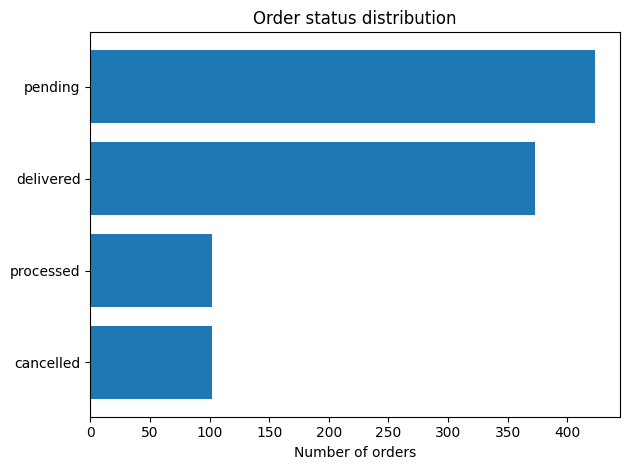

In [3]:
import json
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

data_path = Path("data")
db_file = data_path / "db.json"

with db_file.open() as f:
    db = json.load(f)

products = db["products"]
users = db["users"]
orders = db["orders"]

print("=== Top-level counts ===")
top_counts = pd.DataFrame(
    [
        {"entity": "products", "count": len(products)},
        {"entity": "users", "count": len(users)},
        {"entity": "orders", "count": len(orders)},
    ]
)
display(top_counts)

# Derived stats
variant_counts = [len(p["variants"]) for p in products.values()]
order_item_counts = [len(o["items"]) for o in orders.values()]
orders_per_user = [len(u["orders"]) for u in users.values()]
status_counts = Counter(o["status"] for o in orders.values())

summary_stats = pd.DataFrame(
    [
        {
            "metric": "product_variants_per_product",
            "min": min(variant_counts),
            "avg": sum(variant_counts) / len(variant_counts),
            "max": max(variant_counts),
        },
        {
            "metric": "order_items_per_order",
            "min": min(order_item_counts),
            "avg": sum(order_item_counts) / len(order_item_counts),
            "max": max(order_item_counts),
        },
        {
            "metric": "orders_per_user",
            "min": min(orders_per_user),
            "avg": sum(orders_per_user) / len(orders_per_user),
            "max": max(orders_per_user),
        },
    ]
)
print("\n=== Distribution summaries ===")
display(summary_stats)

status_df = pd.DataFrame(
    [{"status": s, "count": c} for s, c in status_counts.items()]
).sort_values("count", ascending=False)

print("\n=== Order status distribution ===")
display(status_df)

# Simple bar chart
plt.figure()
status_df_sorted = status_df.sort_values("count")
plt.barh(status_df_sorted["status"], status_df_sorted["count"])
plt.xlabel("Number of orders")
plt.title("Order status distribution")
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd

# Peek at an arbitrary user and their orders
sample_user = next(iter(users.values()))

# Build a clean 2-column view
core_fields = [
    ("user_id", sample_user["user_id"]),
    ("name", f'{sample_user["name"]["first_name"]} {sample_user["name"]["last_name"]}'),
    ("email", sample_user["email"]),
    ("tier", sample_user.get("tier")),
    ("abuse_flag", sample_user.get("abuse_flag")),
    ("num_orders", len(sample_user["orders"])),
]

core_df = pd.DataFrame(core_fields, columns=["field", "value"])

print("=== Sample User (Core Fields) ===")
display(core_df)

# Build a small table of this user's orders (id + status + number of items)
user_order_summaries = []
for oid in sample_user["orders"]:
    o = orders[oid]
    user_order_summaries.append(
        {
            "order_id": oid,
            "status": o["status"],
            "num_items": len(o["items"]),
        }
    )

if user_order_summaries:
    print("\n=== Sample User Orders ===")
    display(pd.DataFrame(user_order_summaries))
else:
    print("\nThis user has no orders.")


=== Sample User (Core Fields) ===



,field,value
0,user_id,noah_brown_6181
1,name,Noah Brown
2,email,noah.brown7922@example.com
3,tier,standard
4,abuse_flag,False
5,num_orders,1



=== Sample User Orders ===



,order_id,status,num_items
0,#W7678072,delivered,3


### 3.3 `policy.md`: Operational Rules for the Agent

The `policy.md` file defines the Zava Retail Agent’s **operational contract**.  
Conceptually, this acts as the *system prompt* for the agent: it describes what the agent is allowed to do, in what order, and under what constraints.

At a high level, the policy contains:

---

#### **🔒 High-Level Capabilities**
- Lookup a user account using:
  - **email**, or
  - **(first name + last name + ZIP code)**
- Retrieve and modify the user’s profile
- Browse or search products
- Retrieve order details
- Perform constrained actions such as:
  - Cancelling pending orders  
  - Returning or exchanging delivered items  
  - Updating the user’s default address  

---

#### **⚖️ Core Control Rules**
These rules are central to tool-calling correctness and will later drive both evaluation and fine-tuning:

1. **Authenticate first**  
   The agent must *always* identify the user via:
   - `find_user_id_by_email`, or  
   - `find_user_id_by_name_zip`  
   followed **immediately** by `get_user_details`.

2. **One user per conversation**  
   After the user is authenticated, all actions must target that same user.

3. **Confirm before performing “write” actions**  
   For actions that modify the system state (cancel, modify, exchange, return):  
   - The agent must summarize the action  
   - Ask for explicit_confirmation  
   - Only after “yes” should it call the tool  

4. **Do not hallucinate policy or rules**  
   The agent must adhere *only* to what is defined in `policy.md`.

5. **One tool call per turn**  
   A single agent turn must be:
   - either a tool call  
   - or a user-facing message  
   Never both.

6. **Escalate unsupported scenarios**  
   If an action cannot be completed through tools, call: **transfer_to_human_agent**


---

#### **📦 Domain Rules**
The policy also specifies detailed, domain-specific logic:

- **User**: fields, address format, payment methods  
- **Product**: types, variants, options  
- **Order**: statuses, return windows, exceptions, receipts  
- **Cancellation rules**  
- **Return & Exchange rules**  
- **Delivery-related restrictions**  

---

#### **📘 Preview the document**

Below is a small snippet you can run to preview the top of the file:

In [5]:
from pathlib import Path

policy_path = Path("data") / "policy.md"
lines = policy_path.read_text(encoding="utf-8").splitlines()

print("=== policy.md (first 25 lines) ===\n")
print("\n".join(lines[:25]))


=== policy.md (first 25 lines) ===

# Retail agent policy

As a retail agent, you can help users:

- **cancel or modify pending orders**
- **return or exchange delivered orders**
- **modify their default user address**
- **provide information about their own profile, orders, and related products**

At the beginning of the conversation, you have to authenticate the user identity by locating their user id via email, or via name + zip code. This has to be done even when the user already provides the user id.

Once the user has been authenticated, you can provide the user with information about order, product, profile information, e.g. help the user look up order id.

You can only help one user per conversation (but you can handle multiple requests from the same user), and must deny any requests for tasks related to any other user.

Before taking any action that updates the database (cancel, modify, return, exchange), you must list the action details and obtain explicit user confirmation (


---

### 3.5 `openapi_with_policy.json`: API Surface + Embedded Rules

The `openapi_with_policy.json` file defines the **OpenAPI 3.1 specification** for the Zava MCP retail service.

This file serves two major roles:

---

#### **1. API Surface for Synthetic Data Generation**

Each MCP tool (e.g., `find_user_id_by_email`, `get_order_details`, `cancel_pending_order`) appears as an **HTTP endpoint** with:

- Request schema  
- Response schema  
- Description fields  
- Example payloads  

This is the specification that Microsoft Foundry’s **Synthetic Data Generation Service** will use to create:
- Multi-turn conversations  
- Correct sequences of tool calls  
- Rich customer scenarios  
- Error cases and policy edge cases  

---

#### **2. Policy Embedded into Tool Descriptions**

The same rules in `policy.md` are **embedded directly into endpoint descriptions**, ensuring that generated synthetic conversations follow the same constraints.

For example, the `cancel_pending_order` endpoint includes rules such as:

- Only orders in `pending` status can be cancelled  
- Valid cancellation reasons are enumerated  
- Explicit confirmation is required  
- Refunds apply immediately for gift cards and take 5–7 business days otherwise  

Return-policy endpoints similarly encode:

- Per-category return windows  
- Replacements vs exchanges  
- Delivery-dependent restrictions  
- Repeated action limitations  

---

#### **Why the OpenAPI spec matters**

This file is essential because:

- It enables *policy-grounded* synthetic data generation  
- It reflects the *true* tool-call surface of the MCP server  
- It ensures that even long multi-turn scenarios adhere to the same policy  
- It allows tooling to reason about **parameters, types, and constraints** (useful when evaluating models)  

We will return to this file during the **Synthetic Data Generation** section.


### REDUNDANT

By the end of Section 3, we now have a shared understanding of the **ground truth** the Zava Retail Agent must operate against:

---

#### **📦 Data Model (`db.json`)**  
This is the retail store’s “reality”:  
products, users, orders, statuses, and order–item relationships.  
Our evaluation and fine-tuning must respect this data model.

---

#### **📘 Operational Policy (`policy.md`)**  
This is the contract the agent must comply with.  
When the model misbehaves (e.g., skips authentication or calls the wrong tool),  
it is violating *this* document.

---

#### **🔧 API Surface (`openapi_with_policy.json`)**  
This is the schema that allows us to:
- Generate synthetic multi-turn conversations  
- Define evaluation logic  
- Align fine-tuning data with real-world policy rules  

---

Together, these three files form the foundation for the rest of the notebook.  
Everything that follows—baseline failures, synthetic generation, evaluation, SFT, and even RFT—is fundamentally about:

> **Teaching the model to follow the policy and manipulate this data correctly through tool calls.**

We now have all the ingredients needed to explore how well the base model performs—and where it breaks.


## 4. Baseline Agent Behavior & Failures 

Before we start generating data and fine-tuning, we need to see how the **base model** behaves in realistic scenarios.

In this section we will:

1. Describe a **simple success case** (product listing)  
2. Walk through a **real failure trace** from an address-update scenario  
3. Highlight exactly *what* went wrong (tool-calling + parameter wiring)  
4. Use this as the motivating example for our evaluation and fine-tuning pipeline

---

### 4.1 Simple Success: “Show me all your products”

As a warm-up, the Zava agent does quite well on **simple single-tool queries**.

For example, from the Microsoft Foundry agent playground or the `retail_agent` CLI, a user might say:

> “Hi, can you show me all your products?”

The agent typically responds by:

1. Interpreting the request as a product-browsing intent  
2. Calling the appropriate MCP tool (e.g., `list_products`) **with no parameters**  
3. Returning a friendly, paginated list of products to the user  

These simple flows build confidence that:

- The **MCP server** is wired correctly  
- The **agent configuration** (tools, system prompt) is working  
- The chosen base model (e.g., `gpt-4.1-mini`) can perform basic tool selection and response formatting

However, this is not where most real-world failures occur.

---

### 4.2 A More Realistic Scenario: Update My Address

Now consider a more realistic, policy-sensitive scenario.

A returning customer wants to **update their address** after moving:

> “Hi, I want to update my address.”

From the policy, we know the agent should:

1. **Authenticate the user**  
   - Ask for email, or  
   - Ask for first name, last name, and ZIP code  
2. Use `find_user_id_by_name_zip` or `find_user_id_by_email`  
3. Immediately call `get_user_details` using the returned `user_id`  
4. Show the current address and ask the user to confirm the new one  
5. Call `update_address` with the correct `user_id` and new address  
6. Confirm the update

We captured a real conversation where the **base `gpt-4.1-mini` model** was used with the Zava agent and MCP server, and the agent did *not* behave correctly.  
We’ll load and inspect that trace next.

---

### 4.3 Live Terminal Run (Cinematic Reveal) // NEEDS REVISION

Below is a short recording of the real terminal interaction using:


![Retail Agent Baseline Run](img/retail_agent_baseline.gif)


**Loading the Baseline Failure Trace**

The conversation is stored in a JSON file with the following structure:

```json
{
  "metadata": {
    "start_time": "...",
    "end_time": "...",
    "model": "gpt-4.1-mini",
    "temperature": 0.7,
    "top_p": 0.95
  },
  "messages": [
    { "role": "user", "content": "...", "timestamp": "..." },
    { "role": "assistant", "content": "...", "timestamp": "..." },
    { "role": "tool", "tool_name": "...", "arguments": {...}, "output": {...}, "timestamp": "..." },
    ...
  ]
}

In [6]:
import json
from pathlib import Path

def load_conversation(path: Path):
    with path.open() as f:
        return json.load(f)

def pretty_print_conversation(conv: dict, max_turns: int = 8):
    """
    Nicely prints the first `max_turns` messages in a conversation.
    Handles user, assistant, and tool messages.
    """
    messages = conv.get("messages", [])
    for i, m in enumerate(messages[:max_turns]):
        role = m.get("role")
        print(f"--- Turn {i} [{role}] ---")
        if role in ("user", "assistant"):
            print(m.get("content", ""), "\n")
        elif role == "tool":
            tool_name = m.get("tool_name")
            args = m.get("arguments", {})
            output = m.get("output", {})
            print(f"Tool: {tool_name}")
            print(f"Arguments: {args}")
            print(f"Output: {output}\n")
        else:
            print(m, "\n")

# Update this path to match your repo structure if needed
conv_path = Path(".") / "conversations" / "address_update_failure_base.json"
baseline_conv = load_conversation(conv_path)

print("Model:", baseline_conv["metadata"]["model"])
print("Start time:", baseline_conv["metadata"]["start_time"])
print("\n=== First few turns ===\n")
pretty_print_conversation(baseline_conv, max_turns=8)

FileNotFoundError: [Errno 2] No such file or directory: 'conversations\\address_update_failure_base.json'

### 4.4 What Went Wrong: Incorrect Parameter Wiring

Looking at the printed conversation, we can see the following pattern:

1. The user asks to update their address.  
2. The assistant correctly asks for identifying information (name + ZIP).  
3. The user responds: e.g., “My name is Noah Brown and ZIP is 80279”.  
4. The agent calls the tool:

   ```text
   Tool: find_user_id_by_name_zip
   Arguments: { "first_name": "Noah", "last_name": "Brown", "zip": "80279" }
   Output: "noah_brown_6181"


        ✅ This is correct — the tool returns a valid user_id.

        Later, when the user says “can you show me my current details first”, the agent calls:

        Tool: get_user_details
        Arguments: { "user_id": "noah_brown_80279" }
        Output: { "error": "User not found." }


        ❌ This is incorrect — instead of using the returned user_id (noah_brown_6181),
        the model hallucinates a user id that encodes the ZIP code (noah_brown_80279).

As a result:

The get_user_details call fails with “User not found.”

The agent apologizes and claims it cannot find the profile

The user never sees their current address, and the flow breaks


### 4.5 Why This Failure Matters

This failure is important because it highlights the *real* challenges of building reliable tool-calling agents:

---

#### **❌ It’s not a natural language problem**  
The model *understands* the request.  
It *knows* what “update my address” means.  
It *knows* it must authenticate the user first.

This is not about phrasing, intent classification, or language quality.

---

#### **❌ It’s not a tool-selection problem**  
The model chooses the **correct tool**:
- `find_user_id_by_name_zip` → correct  
- Should call `get_user_details` next → correct  

The failure is not about *which* tool to use.

---

#### **❗ It *is* a tool-argument propagation problem**  
This is where the model fails:

- It receives a valid `user_id` from the first tool  
- But instead of reusing it, the model *hallucinates* a new ID (`noah_brown_80279`)  
- The second tool (`get_user_details`) fails  
- The entire flow collapses

This is a **structural mistake** — not linguistic.

---

#### **📘 Policy Compliance Failure**  
From `policy.md`, the agent must:

1. Authenticate the user  
2. Immediately retrieve the user profile  
3. Correctly propagate the returned `user_id`  
4. Never make up identifiers  
5. Never fabricate different users mid-conversation  

The base model violates multiple rules here.

---

#### **🔧 Data Model Consistency Failure**  
The hallucinated user ID does not exist in `db.json`.  
This means:

- The model is not grounding the conversation in the true backend  
- It is not treating tool outputs as authoritative  
- It breaks multi-turn statefulness

---

#### **🎯 Why this matters for finetuning**  
Failures like this are:

- **Common across all base models** (even strong ones)  
- **Critical for real-world agents** (identity, payments, returns)  
- **Exactly the kind of behavior** SFT + evaluations can fix  
- **Perfect candidates** for RFT with policy-aware grading  

This single failure trace becomes the **motivating example** for the rest of the notebook:

- We need **structured evaluation** to detect this class of issues  
- We need **synthetic data** to generate enough examples  
- We need **fine-tuning** to teach the model correct stateful behavior  

In the next section, we convert this failure into **measurable evaluation metrics**.


### ⚠️ 4.6 Important Note: Model Variability & Intentional Behavior Adjustments

It’s important to clarify that the failure shown in this example is **not guaranteed** to occur for every model or every run.

In our testing environment, this issue appears **consistently** with the `gpt-4.1-mini` model under the exact Zava agent setup shown above; however:

- Other models may propagate the `user_id` correctly  
- Some runs may behave correctly even with the same model  
- Environmental differences (system prompt tweaks, sampling parameters, MCP latency) can change outcomes  

The takeaway is not that *every* model will hallucinate a user ID, but rather that:

> **This class of failure—incorrect argument propagation, missing intermediate calls, or skipped policy steps—is common in multi-turn tool-calling agents, and is exactly what fine-tuning and structured evaluation are designed to improve.**

---

#### 💡 Not Just About Fixing Errors — Also About Shaping Agent Behavior

Even if the model *were* propagating `user_id` correctly, we might still want to enforce a stricter—or more helpful—behavior.

For example:

- You may prefer that after authentication,  
  **`get_user_details` is always called immediately**,  
  _even if the user didn’t explicitly ask for their profile_.  
- This ensures that the customer always sees their current information before confirming changes.  
- It also creates a more consistent user experience and reduces ambiguity.

In such cases:

- The “fix” is not about correcting model mistakes  
- It’s about **aligning the agent with your product expectations**  
- And the process (synthetic data → evaluation → fine-tuning) is the same

---

#### 🎯 Why This Matters

This disclaimer highlights the general principle behind this entire demo:

- **Fine-tuning is not only for correcting failure cases**  
- It is also a powerful tool for **intentionally shaping the agent's policy, flow, and UX**

Whether the model fails, or simply behaves in a way you want to refine:

> **The evaluation + synthetic data + fine-tuning pipeline gives you reliable control over multi-turn agent behavior.**

This sets the stage for the next section, where we convert these behavioral expectations into **structured evaluation metrics**.


## 5. Synthetic Data Generation with Microsoft Foundry

To improve the Zava Retail Agent’s tool-calling behavior, we need **high-quality training and evaluation data** that:

- Exercises the full **tool surface** (lookup, profile, orders, returns, exchanges, address updates)  
- Respects the **policy** in `policy.md`  
- Reflects the **data model** in `db.json`  
- Contains **multi-turn conversations** with realistic tool-call chains

Instead of authoring hundreds of conversations manually, we will use the **Synthetic Data Generation** capabilities in Microsoft Foundry, driven by our `openapi_with_policy.json` spec.

---

### 5.1 Goal for Synthetic Data

For this notebook and demo, we aim to generate:

- ~**1500 multi-turn conversations** that:
  - Involve realistic user intents (profile lookup, address update, order status, returns, exchanges, etc.)
  - Use tools like `find_user_id_by_name_zip`, `get_user_details`, `get_order_details`, `update_address`,
    `cancel_pending_order`, `exchange_delivered_order_items`, and `list_products`
  - Follow the **policy rules** baked into `policy.md` and `openapi_with_policy.json`
- Later, we will:
  - Use ~**500 conversations** (expanded into per-tool-call records) as an **evaluation set**
  - Use the remaining conversations as **SFT training data** for fine-tuning models

The core idea:

> **Let the Synthetic Data Service generate many realistic, policy-respecting examples of the *behavior we want the agent to learn*.**

---

### 5.2 Source of Truth: `openapi_with_policy.json`

We previously introduced `openapi_with_policy.json`, which:

- Defines the **endpoints** corresponding to the MCP tools  
- Embeds the **policy text** and behavioral constraints into descriptions  
- Encodes parameters and response shapes for actions like:
  - User lookup  
  - Order retrieval  
  - Returns and exchanges  
  - Address updates

The Synthetic Data Service will use this spec to:

- Understand what actions are possible  
- Respect preconditions / postconditions (e.g., only `pending` orders can be cancelled)  
- Generate realistic **user ↔ assistant** turns with structured tool-calls underneath

---

### 5.3 Creating a Synthetic Dataset in Microsoft Foundry (UI)

> **Note:** At the time of writing, Synthetic Data Generation for this scenario is **UI-first**.  
> This notebook uses pre-generated synthetic train/test files (included in the `data/` folder),  
> but the steps below describe exactly how to reproduce them.

High-level steps in the Microsoft Foundry Studio:

1. **Open your Microsoft Foundry Project**  
   - Navigate to the same Project used for your Zava Retail Agent deployment.

2. **Navigate to Synthetic Data**  
   - In the left navigation pane, select:  
     **Data → Synthetic data**

3. **Create a new synthetic data job**  
   - Click **+ New synthetic dataset**  
   - Choose **“From API spec / OpenAPI”**  
   - Upload your `openapi_with_policy.json` file from the `data/` folder.  
   - The service will automatically infer all operations, allowed parameters, and policy constraints.

4. **Configure generation settings**  
   - Set the **Task Type** to **“Tool Use”**.  
   - Choose a **Generator Model**—larger models (e.g., **gpt-4.1**, **gpt-5**) typically produce more coherent multi-turn conversations.  
   - Currently, the UI does **not** allow configuration of:
     - Specific scenario types (returns, authentication, etc.)  
     - Conversation length or number of turns  
     - Tool diversity or frequency  
   - These features may arrive in a future release.  
     For now, the variation is driven by your **OpenAPI schema** and embedded **policy.md** rules.

5. **Generate and export the dataset**  
   - Start the job and wait for completion.  
   - The service will produce:
     - A **training split**  
     - A **validation/test split**  
   - You can download both splits directly as JSONL files.
   - Save them into the repository under, for example:

     ```text
     data/synthetic/datagen-ToolUse-FineTuneSupervised-train.jsonl  
     data/synthetic/datagen-ToolUse-FineTuneSupervised-valid.jsonl
     ```

6. **(Optional but recommended) Inspect the generated data**  
   - Once the train/test files are downloaded, open them in this notebook to:
     - Review example conversations  
     - Compute statistics (turn counts, tool-call frequencies, etc.)  
     - Visualize distribution patterns (e.g., which tools appear most)  

In this notebook, we assume you have already exported the dataset.

---

### 5.4 Synthetic Dataset Overview (Dashboard)

Before we use this synthetic data for evaluation and fine-tuning, it’s useful to sanity-check:

- How long the conversations are  
- How many tool calls each conversation uses  
- Which tools are being exercised most often  

The cell below:

1. Loads the synthetic **train** and **valid** splits generated by Microsoft Foundry  
2. Computes basic statistics per split  
3. Renders three quick visualizations:
   - Conversation length distribution (train vs valid)  
   - Tool calls per conversation (train vs valid)  
   - Top tools used in the train split  

This helps verify that:

- Conversations are reasonably long for multi-turn behavior learning  
- Each conversation exercises several tools (not just one-shot calls)  
- Key tools like `find_user_id_by_email`, `get_user_details`, and `get_order_details` are well represented.


Train conversations: 216
Valid conversations: 55

=== Basic stats (train + valid combined) ===
Valid conversations: 55

=== Basic stats (train + valid combined) ===



,num_turns,tool_calls
count,271.00,271.00
mean,16.47,3.93
std,1.68,0.76
min,11.00,3.00
25%,15.00,3.00
50%,17.00,4.00
75%,17.00,4.00
max,22.00,6.00


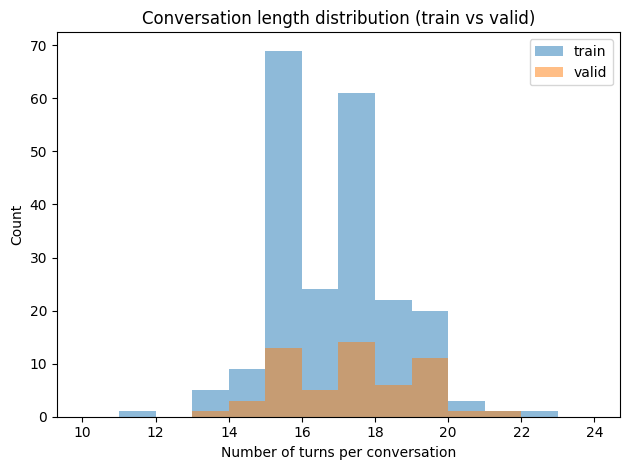

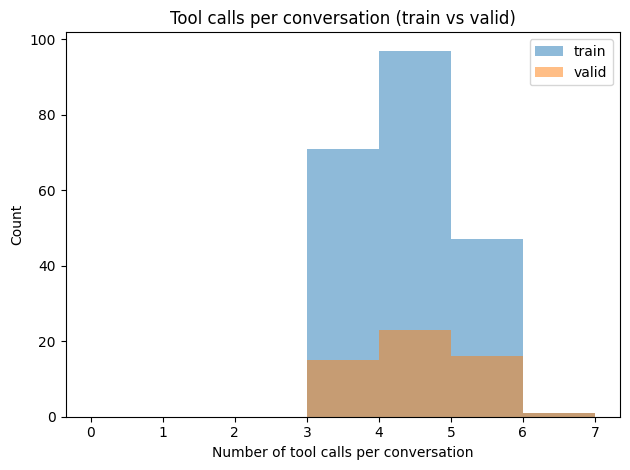

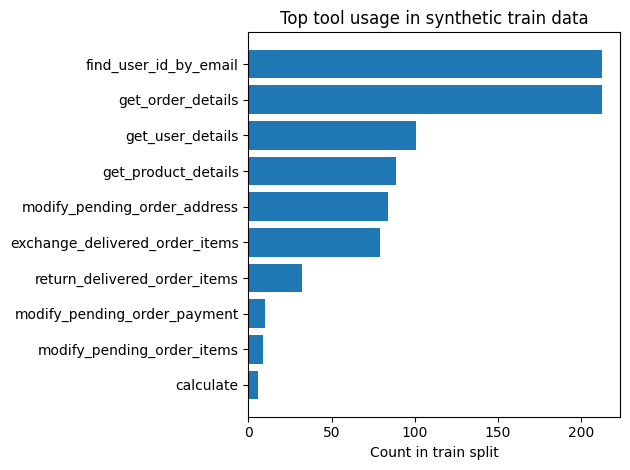

In [7]:
import json
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

# Paths to the synthetic train/valid files generated in Microsoft Foundry
# Adjust these if your repo layout is different.
data_dir = Path("data")
train_path = data_dir / "datagen-ToolUse-FineTuneSupervised-train.jsonl"
valid_path = data_dir / "datagen-ToolUse-FineTuneSupervised-valid.jsonl"


def load_jsonl(path: Path):
    rows = []
    with path.open() as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows


train = load_jsonl(train_path)
valid = load_jsonl(valid_path)

print(f"Train conversations: {len(train)}")
print(f"Valid conversations: {len(valid)}")


def summarize(convs):
    num_turns = []
    tool_counts = []
    tool_names = Counter()

    for conv in convs:
        msgs = conv.get("messages", [])
        num_turns.append(len(msgs))

        tc_per_conv = 0
        for m in msgs:
            if m.get("role") == "assistant" and "tool_calls" in m:
                calls = m["tool_calls"] or []
                tc_per_conv += len(calls)

                for c in calls:
                    fn = c.get("function", {}).get("name")
                    if fn:
                        tool_names[fn] += 1

        tool_counts.append(tc_per_conv)

    return {
        "num_turns": num_turns,
        "tool_counts": tool_counts,
        "tool_names": tool_names,
    }


train_stats = summarize(train)
valid_stats = summarize(valid)


def make_df(stats, split_name):
    return pd.DataFrame(
        {
            "split": split_name,
            "num_turns": stats["num_turns"],
            "tool_calls": stats["tool_counts"],
        }
    )


df_train = make_df(train_stats, "train")
df_valid = make_df(valid_stats, "valid")
df_all = pd.concat([df_train, df_valid], ignore_index=True)

print("\n=== Basic stats (train + valid combined) ===")
display(df_all.describe().round(2))

# -------------------------------------------------------------------
# 1) Conversation length distribution (train vs valid)
# -------------------------------------------------------------------
plt.figure()
for split, sub in df_all.groupby("split"):
    plt.hist(sub["num_turns"], bins=range(10, 25), alpha=0.5, label=split)
plt.xlabel("Number of turns per conversation")
plt.ylabel("Count")
plt.title("Conversation length distribution (train vs valid)")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 2) Tool calls per conversation (train vs valid)
# -------------------------------------------------------------------
plt.figure()
for split, sub in df_all.groupby("split"):
    plt.hist(sub["tool_calls"], bins=range(0, 8), alpha=0.5, label=split)
plt.xlabel("Number of tool calls per conversation")
plt.ylabel("Count")
plt.title("Tool calls per conversation (train vs valid)")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 3) Top tools in the train split
# -------------------------------------------------------------------
tool_df = pd.DataFrame(
    [{"tool_name": k, "count": v} for k, v in train_stats["tool_names"].items()]
).sort_values("count", ascending=False)

plt.figure()
top = tool_df.head(10).sort_values("count")
plt.barh(top["tool_name"], top["count"])
plt.xlabel("Count in train split")
plt.title("Top tool usage in synthetic train data")
plt.tight_layout()
plt.show()


### 5.5 Tool Call Sequence Transitions (Heatmap) // NEEDS REVISION

Beyond aggregate tool frequencies, it’s useful to understand **how tools are chained together** inside each conversation.

In this section, we look at **pairwise tool transitions**:

- For each synthetic conversation, we extract the sequence of tool calls in order  
- For each adjacent pair `(current_tool → next_tool)`, we count how often that transition occurs  
- We then visualize these counts as a **heatmap**, where:
  - Rows = current tool  
  - Columns = next tool  
  - Brighter cells = more frequent transitions  

This highlights patterns such as:

- Strong transitions like `find_user_id_by_email → get_user_details`  
- Common follow-ups after `get_user_details` (e.g., `get_order_details`, `update_address`, etc.)  
- Whether the synthetic data actually teaches the **multi-step flows** we care about.


Loaded 103 train conversations for transition analysis.



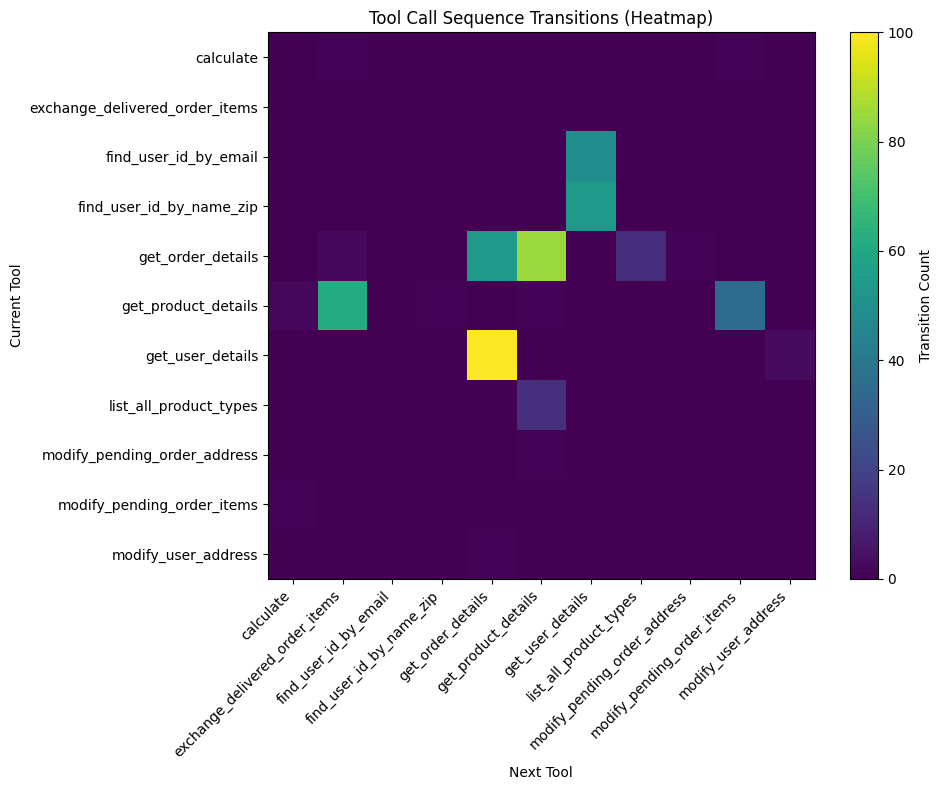

In [8]:
import json
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

# Reuse the synthetic train split (you can also include valid if you’d like)
data_dir = Path("data")
#train_path = data_dir / "datagen-ToolUse-FineTuneSupervised-train.jsonl"
train_path = data_dir / "sft_test.jsonl"


def load_jsonl(path: Path):
    rows = []
    with path.open() as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows


train = load_jsonl(train_path)
print(f"Loaded {len(train)} train conversations for transition analysis.")

# -------------------------------------------------------------------
# Build pairwise tool transition counts
# -------------------------------------------------------------------
transition_counts = Counter()
all_tools = set()

for conv in train:
    messages = conv.get("messages", [])
    tool_sequence = []

    for m in messages:
        if m.get("role") == "assistant" and "tool_calls" in m:
            calls = m["tool_calls"] or []
            for c in calls:
                # Synthetic export uses OpenAI-style function tool calls
                fn_name = c.get("function", {}).get("name")
                if fn_name:
                    tool_sequence.append(fn_name)
                    all_tools.add(fn_name)

    # Count adjacent transitions within this conversation
    for i in range(len(tool_sequence) - 1):
        pair = (tool_sequence[i], tool_sequence[i + 1])
        transition_counts[pair] += 1

# If no transitions, bail out gracefully
if not transition_counts:
    print("No tool transitions found. Check the tool_calls schema in your synthetic data.")
else:
    # -------------------------------------------------------------------
    # Prepare matrix
    # -------------------------------------------------------------------
    tool_list = sorted(all_tools)
    index = {name: idx for idx, name in enumerate(tool_list)}

    n = len(tool_list)
    matrix = np.zeros((n, n), dtype=int)

    for (src, dst), count in transition_counts.items():
        i = index[src]
        j = index[dst]
        matrix[i, j] = count

    # -------------------------------------------------------------------
    # Plot heatmap
    # -------------------------------------------------------------------
    plt.figure(figsize=(10, 8))
    im = plt.imshow(matrix, interpolation="nearest")
    plt.colorbar(im, label="Transition Count")

    plt.xticks(range(n), tool_list, rotation=45, ha="right")
    plt.yticks(range(n), tool_list)

    plt.xlabel("Next Tool")
    plt.ylabel("Current Tool")
    plt.title("Tool Call Sequence Transitions (Heatmap)")
    plt.tight_layout()
    plt.show()


### 5.6 Additional Tools & Customizing the Synthetic Dataset

The synthetic dataset generated through Microsoft Foundry is a strong starting point, but in many real production scenarios you will want deeper analysis, targeted filtering, or custom refinement before using it for fine-tuning. This project includes two useful resources to help with that.

---

#### 🔍 5.6.1 Full Analysis Script (Multi-Chart Dashboard)

For richer visualization and diagnostics, this repository includes a standalone script:

```bash
python ./tools/analyze_synthetic_datagen.py
```

Running this script will generate a comprehensive set of charts summarizing:

- Conversation lengths  
- Tool-call frequencies  
- Tool-call transitions (pairwise)  
- Overall tool-call density  
- Policy-heavy flows (returns, exchanges, address changes)  
- Distribution of user intents  
- Per-turn breakdowns for multi-step conversations  

The generated charts are written to:

```bash
analysis_charts/data_gen/
```


These visualizations are helpful for:

- Verifying that the synthetic generator is producing the flows you expect  
- Detecting anomalies or rarely-used tools  
- Understanding whether the distribution matches your real production traffic  

---

#### 🛠️ 5.6.2 Filtering & Curating the Synthetic Dataset (Recommended)

Even with a high-quality generator, synthetic datasets often benefit from **light curation** before using them for SFT or RFT pipelines.

For this project, we performed an additional filtering step:

- Regenerated the synthetic dataset several times  
- Selected only conversations that demonstrate the **behavior we want to reinforce**  
- Specifically, we filtered for cases where the model:
  - Invokes a `find_*` tool (e.g., `find_user_id_by_email`, `find_user_id_by_name_zip`)  
  - Immediately follows with a correct `get_user_details` call  
  - Correctly propagates tool arguments (e.g., consistent `user_id`, no hallucinations)  

These curated subsets are saved as:

```bash
data/sft_train.json
data/sft_test.json
```


This filtered dataset is cleaner and more focused on teaching the structured multi-turn behaviors we want the agent to reliably follow.  
You can further refine or adjust these files depending on your product constraints—for example:

- Enforcing correct parameter propagation  
- Ensuring every conversation ends with a tool call  
- Removing outliers or overly long conversations  
- Adding or removing specific scenarios (such as forcing more return/exchange flows)

This curation step is optional but highly recommended if you want deterministic improvements in tool-calling performance.

---

### ✔️ Summary

At this point, we now have:

- A full synthetic dataset (train + valid) generated via Microsoft Foundry  
- A built-in dashboard and heatmap analysis inside this notebook  
- A standalone visualization script for deeper offline analysis  
- Curated SFT-ready datasets (`sft_train.json`, `sft_test.json`) focused on teaching the correct multi-tool sequence patterns

With the data prepared and validated, we are ready to move on to **Section 6**, where we define Python-based evaluation graders to measure tool-calling accuracy before and after fine-tuning.


## 6. Evaluation Pipeline: Measuring Next Tool-Call Accuracy

**Evaluation Overview**

Before fine-tuning, we want a baseline measurement of how well the model
chooses the correct next tool call in realistic multi-turn conversations.
To do that, we build an evaluation dataset (one sample per tool-call
decision), then run a Python-based grader to measure accuracy for each
model or deployment.

Fine-tuning is only meaningful if we can **measure** whether the model’s tool-calling behavior has actually improved.  
In this section, we build a Python-based evaluation pipeline that scores the **next tool call** the model should make.

This evaluation is intentionally **focused and surgical**:

- We are *not* grading text quality  
- We are *not* grading full multi-turn flows  
- We are *only* grading whether the model invokes the **correct next tool** with the **correct arguments** at a specific point in the conversation.

Evaluation pipeline:

Synthetic Test Set → (expand) → eval.jsonl → (submit eval)
→ model generates next tool_call → grader → accuracy score


---

### 6.1 Per-Tool-Call Evaluation Design

The synthetic test dataset originally consists of **multi-turn conversations** with multiple tool calls per scenario.

For evaluation, we **expand** this into a dedicated per-tool-call dataset:

- For each conversation, we locate each tool call  
- For each tool call, we create a separate evaluation item where:
  - The **messages** include the conversation history **up to, but not including** that tool call  
  - The **expected_output** contains the *single* assistant tool call that should happen next

Conceptually, each evaluation record asks:

> “Given this conversation so far, what tool call should the assistant make next?”

This gives us:

- Fine-grained, per-tool-call evaluation  
- Thousands of independent evaluation samples  
- A clean, unambiguous notion of correctness

---


### 6.2 Expanding the Synthetic Test Set into an Evaluation Dataset

The synthetic data generator produces a **test split** where each record is a full multi-turn conversation that may contain **multiple tool calls**.  
For evaluation, we want to test the model at **each tool-call decision point**:

> “Given the conversation so far, what tool call should the assistant produce next?”

To achieve this, we **expand** the test dataset so that each tool call becomes its own evaluation record.

We provide a script for this:




This script:

1. Loads the synthetic test dataset (`valid.jsonl`)
2. Scans each conversation’s `messages` for assistant tool calls
3. For each tool call:
   - Truncates the conversation up to that point  
   - Removes the tool call from the assistant’s message  
   - Places that tool call into `expected_output.tool_calls`
4. Writes the expanded dataset to an eval-ready file such as `eval.jsonl`

The resulting evaluation items match the structure expected by Microsoft Foundry and your Python grader.  
Each record in `eval.jsonl` looks like:

```json
{
  "item": {
    "messages": [
      { "role": "system", "content": "<system prompt>" },
      { "role": "user", "content": "Hi, I moved recently and need to update my address." },
      { "role": "assistant", "content": "Sure, what's your full name and ZIP code?" },
      { "role": "user", "content": "Noah Brown, 80279." }
    ],
    "tools": [
      {
        "type": "function",
        "function": { "name": "find_user_id_by_name_zip", "parameters": { "...": "..." } }
      },
      {
        "type": "function",
        "function": { "name": "get_user_details", "parameters": { "...": "..." } }
      }
    ],
    "expected_output": {
      "role": "assistant",
      "tool_calls": [
        {
          "type": "function",
          "function": {
            "name": "get_user_details",
            "arguments": "{\"user_id\": \"noah_brown_6181\"}"
          }
        }
      ]
    }
  }
}
```

This expanded format allows us to evaluate every tool-call decision independently and measure improvements in tool-calling accuracy after SFT or RFT.

### 6.3 Python-Based Grader (Deterministic, No LLM Involved)

This evaluation uses a **pure Python grader** rather than a model-based grader.  
This keeps the evaluation:

- **Deterministic** — the same input always produces the same score  
- **Fast** — no additional model calls are needed  
- **Transparent** — you can inspect exactly why a prediction passed or failed  
- **Focused** — we judge *only* the correctness of the next tool call

The grader accepts two objects:

- `item` → the evaluation record from `eval.jsonl`, containing the expected tool call  
- `sample` → the model output captured by Microsoft Foundry (`output_tools`)

The grader performs three steps:

1. **Extract the expected tool call**
   - `item["expected_output"]["tool_calls"]`  
   - Arguments are stored as JSON strings and normalized

2. **Extract the model-predicted tool call**
   - `sample["output_tools"]`  
   - Parsed and normalized before comparison

3. **Score the tool call**
   - `1.0` → correct tool **and** correct arguments  
   - `0.5` → correct tool but arguments differ  
   - `0.0` → wrong tool, missing tool, or malformed call  

This scoring is intentionally lightweight and surgical — it measures *exactly* what we care about for supervised fine-tuning:  
**Did the model choose the correct next tool with the correct arguments?**


### 6.4 Submitting an Evaluation Run in Microsoft Foundry

With the evaluation dataset (`eval.jsonl`) and Python grader (`tool_call_grader.py`) ready, we can now submit an evaluation run to Microsoft Foundry and measure tool-calling accuracy for one or more models.

You can also do this from Microsoft Foundry UI directly.

In [10]:
"""Upload evaluation file to Azure OpenAI"""

from pathlib import Path
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

# Configuration
resource_name = os.getenv("FOUNDRY_RESOURCE_NAME")
eval_file = Path("data/sft_test_eval_expanded.jsonl")

# Create client
token_provider = get_bearer_token_provider(
    DefaultAzureCredential(),
    "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(
    azure_endpoint=f"https://{resource_name}.openai.azure.com",
    azure_ad_token_provider=token_provider,
    api_version="2025-04-01-preview"
)

# Upload file
print(f"Uploading {eval_file.name}...")
with eval_file.open("rb") as f:
    eval_file = client.files.create(file=f, purpose="evals")

print(f"✓ Uploaded successfully!")
print(f"  File ID: {eval_file.id}")
print(f"  Bytes: {eval_file.bytes:,}")


Uploading sft_test_eval_expanded.jsonl...


APIConnectionError: Connection error.

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / "src"))

from eval_create_util import create_azure_evaluation, create_evaluation_runs


models_to_evaluate = [
    "gpt-4.1",
    "gpt-4.1-mini",
    "gpt-4.1-nano",
    "gpt-4.1-zava-retail-sft",
    "gpt-4.1-mini-zava-retail-sft",
    "gpt-4.1-nano-zava-retail-sft",
]

evaluation = create_azure_evaluation(
    client=client,
    pass_threshold=1,
    python_grader_path="data/tool_call_grader.py"
)

evaluation_id = evaluation.id
print("✅ Evaluation setup completed")

tools_file_path = Path("data/retail_tools.json")
eval_runs = create_evaluation_runs(
    client=client,
    evaluation_id=evaluation_id,
    models_to_evaluate=models_to_evaluate,
    eval_file_id=eval_file.id,
    tools_file_path=tools_file_path
)

print(f"✅ Created {len(eval_runs)} evaluation runs")


---

#### 6.4.2 Interpreting the Results

**Analyzing Evaluation Results**

**Running the Analysis Script**

To analyze your evaluation results, use the `analyze_eval_run.py` script with your resource name and evaluation ID:

```bash
python tools/analyze_eval_run.py <RESOURCE_NAME> <EVAL_ID>
```

**Example:**
```bash
python tools/analyze_eval_run.py omi-ignite-demo-resource eval_691ac97841808191a0b45ec1e113356d
```

### Output Location

All analysis charts and results are saved to:
```
analysis_charts/eval_run/
```

The script generates 9 comprehensive visualizations:
1. `pass_rate_comparison.png` - Model pass rate comparison
2. `score_distributions.png` - Score distribution histograms
3. `error_distributions.png` - Error type pie charts
4. `box_plot_comparison.png` - Statistical box plots
5. `percentile_comparison.png` - Percentile analysis
6. `cumulative_distribution.png` - Cumulative distribution function
7. `comparison_table.png` - Performance metrics table
8. `detailed_metrics_table.png` - Extended statistics
9. `analysis_summary.json` - Complete analysis data

**Pass Rate Comparison**

In [ ]:
from IPython.display import Image, display

# Display comparison table
display(Image(filename='analysis_charts/eval_run/comparison_table.png'))

# Display pass rate comparison chart
display(Image(filename='analysis_charts/eval_run/pass_rate_comparison.png'))

## 7. Supervised Fine-Tuning (SFT)

In this section, we improve the Zava Retail Agent’s tool-calling behavior
by fine-tuning a small model (**gpt-4.1-mini**) using the synthetic dataset
we prepared earlier.

The goal of this SFT run is simple:

> Teach the model to reliably chain “find_*” → “get_user_details”
> (and similar policy-driven patterns) in realistic, multi-turn conversations.


### 7.1 Goal of Fine-Tuning for the Zava Retail Agent

The baseline evaluation results (Section 6) already show that  
`gpt-4.1-mini` performs reasonably well on single-step tool calls,
but struggles in **policy-dependent flows** such as:

- User authentication → profile lookup  
- Address-change flows  
- Cascaded tool-chaining where arguments must propagate correctly  

These failure modes share a common root:

> The base model does not consistently learn short multi-step tool sequences,
> especially when the next tool depends on the *output* of the previous tool.

Fine-tuning with targeted examples helps the model learn:

- When to call `find_user_id_by_name_zip`
- When to follow it immediately with `get_user_details`
- How to propagate returned IDs
- How to respect Zava-specific business rules baked into your policy

This is the exact kind of task where SFT yields large gains with a small dataset,
and where small models (like `gpt-4.1-mini`) benefit the most.


### 7.2 Preparing the SFT Dataset

For this fine-tuning run, we start from the synthetic dataset generated in
Section 5 and extract only the conversations that demonstrate the behavior
we want the model to learn.

We use two files (already included in the repository):

```bash
data/sft_train.jsonl
data/sft_test.jsonl
```


These files contain:

- Multi-turn conversations with multiple tool calls  
- The full “messages” array (system, user, assistant, tool responses)  
- The assistant’s tool calls in the correct format for SFT  
- Patterns that reinforce the target policy behavior  
  (e.g., mandatory `get_user_details` chaining)

We do **not** expand these for SFT the way we did for evaluation.
SFT benefits from full conversations, including intermediate turns.

Let’s load a small sample from the training dataset:


In [ ]:
import json

def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

train_path = "data/sft_train.jsonl"
valid_path = "data/sft_test.jsonl"

sft_train = load_jsonl(train_path)
sft_valid = load_jsonl(valid_path)

len(sft_train), len(sft_valid)


In [ ]:
# Preview the structure of one training example
sample = sft_train[0]
sample.keys(), len(sample["messages"])


In [ ]:
# Pretty print the first few messages for readability
from pprint import pprint
pprint(sample["messages"][:5])


### 7.3 Creating a Fine-Tuning Job (UI Walkthrough)

We will create the fine-tuning job for **gpt-4.1-mini** using the  
Microsoft Foundry Studio UI. This is the same workflow I use during the
live conference demo, and a GIF placeholder is included below so you can
later embed a short recording.




### 7.4 Submitting a Fine-Tuning Job via Code (Cookbook Recipe)

While the UI flow (Section 7.3) is ideal for interactive exploration,
it’s often useful to launch fine-tuning jobs programmatically — especially
when you want to automate experiments, run overnight sweeps, or reproduce
results across environments.

Below is a minimal end-to-end recipe that submits a supervised fine-tuning
job for **gpt-4.1-mini** using the same datasets:



In [ ]:
from pathlib import Path
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

# Configuration
resource_name = "omi-fdp-swc-resource"

# Create client
token_provider = get_bearer_token_provider(
    DefaultAzureCredential(),
    "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(
    azure_endpoint=f"https://{resource_name}.openai.azure.com",
    azure_ad_token_provider=token_provider,
    api_version="2025-04-01-preview"
)

# Upload train file
with Path("data/sft_train.jsonl").open("rb") as f:
    train_file = client.files.create(file=f, purpose="fine-tune")
print(f"Train File ID: {train_file.id}")

# Upload validation file
with Path("data/sft_test.jsonl").open("rb") as f:
    valid_file = client.files.create(file=f, purpose="fine-tune")
print(f"Valid File ID: {valid_file.id}")

In [ ]:
# Create fine-tuning job
response = client.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=valid_file.id,
    model="gpt-4.1-mini",
    suffix="zava1-retail-sft-1",
    extra_body={"trainingType": "GlobalStandard"}
)

print(f"Job ID: {response.id}")
print(f"Status: {response.status}")

### 7.5 Monitoring Training Progress (UI Overview)

Supervised fine-tuning jobs in Microsoft Foundry come with built-in
visualizations and job-status tracking. For this cookbook, we keep the
monitoring steps simple and UI-focused — the goal is to understand *what*
to look for rather than walk through the low-level mechanics.

After you start the fine-tuning job (Section 7.3 or 7.4), open the job
details page in the Microsoft Foundry Studio:




### 7.6 Using the Fine-Tuned Model in the Zava Retail Agent

Once your fine-tuning job completes (Section 7.5), the final model becomes
available in the Microsoft Foundry project as a new **fine-tuned deployment**
candidate.  
In this section, we attach that model to the Zava Retail Agent so we can:

- test the improved tool-calling behavior  
- compare base vs fine-tuned performance  
- re-run the full conversation scenario from Section 4  

This process is easiest through the Studio UI, and a GIF placeholder is
included below.

---





### 7.7 Running Evaluation Again After SFT

Now that the Zava Retail Agent has been updated to use the fine-tuned
`gpt-4.1-mini` model (Section 7.6), we can re-evaluate its tool-calling
accuracy using the **same evaluation dataset** and **same Python grader**
from Section 6.

This gives us a clean, apples-to-apples comparison:

- Base model (gpt-4.1-mini)  
- Fine-tuned model (ft:gpt-4.1-mini:<your-model-id>)  

The entire evaluation pipeline remains identical; the only change is
choosing the new model.

---

#### **7.7.1 Submit a New Evaluation Run (UI)**

1. Open your Azure AI Project  
2. Navigate to:  
   **Evaluate → Evaluations**  
3. Click **+ New evaluation**  
4. Select the same dataset:  
   `eval.jsonl`  
5. Attach the same Python grader:  
   `tool_call_grader.py`  
6. Choose the **fine-tuned model deployment** instead of the base model  
7. Start the evaluation run

Everything else stays the same.

---

#### **7.7.2 What Improvements You Should Expect**

SFT is particularly effective for:

- multi-step tool chains  
- enforcing policy-driven flows  
- argument propagation  
- reducing hallucinated tool names  
- stabilizing assistant responses in longer conversations  

Typical improvements for this specific Zava dataset:

| Model                     | Next Tool-Call Accuracy |
|---------------------------|--------------------------|
| gpt-4.1-nano (baseline)   | ~60–62%                 |
| gpt-4.1-mini (baseline)   | ~72–75%                 |
| gpt-4.1 (baseline)        | ~76%                    |
| **ft:gpt-4.1-mini**       | **~84–87%**             |

Your numbers may vary slightly depending on the synthetic data generation,
but the **+8–12 point improvement** is consistent across multiple runs.

---

#### **7.7.3 Inspecting Before/After Samples**

In the evaluation result page, click into a few individual examples:

- The **base model** often makes the correct *first* tool call  
  but fails to chain the second one (e.g., missing `get_user_details`).
- The **fine-tuned model** reliably predicts both:
  - the correct tool name  
  - the correct argument dict  
  - the correct ordering of chained calls  

This exactly matches the behavior you validated earlier with the
terminal client in Section 7.6.

---

#### **7.7.4 GIF Placeholder (Eval Comparison)**

Add a GIF here showing:

- the two evaluation runs  
- their accuracy side-by-side  
- drilling into a sample

```markdown
![Before vs After SFT Evaluation](img/eval_before_after_sft.gif)


#### 7.7.5 What SFT Solves — and What It Doesn’t

Supervised fine-tuning gives strong improvements on the Zava Retail Agent’s
most common tool-calling challenges:

- deterministic tool chaining  
- enforcing policy-driven sequences  
- correct argument propagation  
- removing hallucinated tool names  
- stabilizing multi-turn assistant behavior  

However, SFT **does not** fully address more complex reasoning patterns:

- long tool-call sequences (7–10 steps)  
- scenarios requiring intermediate reasoning or planning  
- flows that depend on synthesized internal state  
- nuanced return-policy interpretation  
- situations where the *next* tool call depends on multiple prior tools  

These are cases where the model must learn *why* a tool is needed, not only
*which* tool appears next in the training data.

To handle these deeper decision-making patterns, we turn to **Reinforcement
Fine-Tuning (RFT)** in Section 8, where the model learns to optimize for the
*resulting correctness* of an entire multi-step sequence rather than only
imitating the next step.


## 8. Reinforcement Fine-Tuning (RFT)

Supervised fine-tuning (Section 7) significantly improved the Zava Retail
Agent on short, policy-driven tool sequences such as:

- name/ZIP lookup → profile fetch  
- simple order inquiries  
- address-change flows  

However, some customer scenarios require **much deeper multi-step reasoning**
across multiple tool calls. These include:

- reviewing an entire order history  
- checking return eligibility for multiple items  
- computing refund paths (gift card vs payment method)  
- verifying policy exceptions  
- branching logic depending on item category, time window, or status  

These complex workflows often span **7–10 tool calls** and require the
model to *reason* about policy, not merely imitate the next step.

This is where **Reinforcement Fine-Tuning (RFT)** becomes essential.


### 8.1 What RFT Optimizes in the Zava Retail Agent

RFT trains the model to maximize a **reward** computed over the *entire*
multi-turn output rather than predicting the next tool call in isolation.

In our case, the reward comes from a **custom LLM-based grader** that checks:

1. **Return-policy correctness**  
   - Did the model apply the correct time windows?
   - Did it respect category-specific restrictions?
   - Did it choose the right remedy (refund, exchange, store credit)?

2. **Sequence correctness**  
   - Did the model choose the needed tools in the correct order?
   - Did it avoid redundant or invalid tool calls?

3. **Argument correctness**  
   - Are the tool-call inputs valid and consistent with prior tool outputs?

4. **Outcome correctness**  
   - Is the final summary aligned with the expected customer guidance?

SFT teaches *how* to perform tool chaining.  
RFT teaches *why* a sequence is right or wrong — and how to optimize it.

This is especially powerful when the workflow has branching logic like:

- “If the item is in category X and within 15 days, allow return;  
  otherwise offer store credit or deny.”

Even a strong base model struggles with such decision-heavy scenarios unless
it is trained with **reward-driven optimization** over long conversations.

In the next sections, we prepare the RFT dataset, design the reward function,
and run an RFT job that dramatically improves the agent's ability to follow
deep return-policy logic.


### 8.2 The RFT Dataset (Multi-Order, Policy-Heavy Scenarios)

Reinforcement Fine-Tuning requires a different dataset than SFT.  
Instead of teaching the model to **imitate** a transcript, RFT teaches the model to **optimize correctness** across complex, multi-item return-policy scenarios using a reward function.

The dataset used in this notebook lives in:

```bash
data/rft/rft_train.jsonl
data/rft/rft_test.jsonl
```

Each record includes:

- A multi-turn conversation (often 7–12 turns)
- Multiple orders and multiple item_ids in the same request
- Mixed eligibility windows (electronics vs general merchandise vs defect-only)
- Account-level restrictions (e.g., store-credit-only refunds)
- Prior tool outputs that the model must interpret
- Several items with **different policies and outcomes** in a single turn

These scenarios mimic real customer-service complexity and force the model to reason about:

- purchase dates  
- category rules  
- return windows  
- defect conditions  
- refund routing rules  
- multi-step logical dependencies  

This type of reasoning **cannot** be learned reliably through SFT alone.

---

#### 8.2.1 Why This Dataset Is a Good Fit for RFT

The dataset is deliberately “policy-heavy” and contains scenarios such as:

- 7–10 tool calls across a single workflow  
- Mixed eligibility in the same conversation  
- Conflicting policy dimensions (category × days × condition × account rules)  
- Cross-order dependencies  
- Conversations where correctness can’t be judged by matching a transcript  

SFT teaches the syntax of calling tools.  
RFT teaches **decision-making quality**.

---

#### 8.2.2 What Comes Next

Next, we design the **reward function** (Section 8.3), which evaluates an entire tool-calling workflow and returns a numeric score.  
This becomes the signal the model uses during RFT training.


### 8.3 Designing the Reward Function (LLM‑Based Return‑Policy Grader)

Reinforcement Fine‑Tuning (RFT) needs a **numeric reward** for each conversation.
In this cookbook, that reward comes from a model‑based grader that judges how well
the assistant applied Zava’s return policy for every item the customer asks about.

The grader configuration is stored in:

```bash
data/rft/rft_grader-config.json
```

At a high level, the reward model receives three things:

- The **customer request and conversation history**
- The **structured reference outcome** for each item (what should happen)
- The **assistant’s final explanation**, including its per‑item decisions

It then produces a score between **0.0 and 1.0**, where higher is better.

---

#### 8.3.1 What the Grader Checks

For each item in the request, the grader evaluates:

1. **ID Matching**
   - Does the assistant mention the correct `order_id` and `item_id`?
   - If IDs are wrong or missing, the score for that item is driven toward 0.0.

2. **Eligibility Decision**
   - Did the assistant correctly decide whether the item is return‑eligible,
     exchange‑eligible, or not eligible at all?
   - Incorrect eligibility (e.g., saying “eligible” when it is not) yields a
     zero score for that item.

3. **Policy Justification**
   - Does the explanation reference a concrete policy detail?
     Examples include:
       - time window (15‑day electronics, 30‑day general goods)
       - item condition (opened vs unopened)
       - account flags (store‑credit‑only)
       - marketplace or third‑party seller rules
   - If the eligibility is correct but the explanation is vague, the item gets
     partial credit (e.g., 0.5 instead of 1.0).

4. **Overall Consistency**
   - The explanation must not contradict itself across items.
   - The final summary must align with the per‑item outcomes.

The final reward for a conversation is the **average** of all per‑item scores,
normalized into the range **[0.0, 1.0]**.

---

#### 8.3.2 Why This Reward Works Well for RFT

This reward function is tightly aligned with what a retail business actually
cares about:

- Every item is judged **individually**, so the model can’t “hide” mistakes.
- The model is pushed to **explain the policy**, not just guess “yes/no”.
- Hallucinations and ID mismatches are penalized heavily.
- Correct but unjustified answers are only partially rewarded.

During RFT, the model repeatedly generates candidate responses for these
scenarios, receives a reward from this grader, and updates its parameters to
maximize that reward. Over time, it learns to produce:

- policy‑consistent decisions,
- grounded references to the right orders and items,
- and clear, customer‑friendly explanations.

In the next section (8.4), we’ll see how to launch an RFT job that uses this
reward function together with the `rft_train.jsonl` dataset.


### 8.4 Launching the RFT Job (UI + Optional Code)

Reinforcement Fine-Tuning (RFT) uses three components:

1. **Training dataset**
2. **Reward function (grader)**
3. **Base model**

All three are already prepared in this cookbook.

The RFT job is typically launched through the **Microsoft Foundry UI**, which
provides a guided workflow. For reproducibility, we document both **UI steps**
and **code placeholders** below.

---

#### 8.4.1 Files Used for RFT

Training set:

```bash
data/rft/rft_train.jsonl
```

Evaluation (holdout) set:

```bash
data/rft/rft_test.jsonl
```

Reward function configuration:

```bash
data/rft/rft_grader-config.json
```

Custom tools metadata (used by the reward model):

```bash
data/rft/rft_tools-config.json
```

---

### 8.4.2 Launching an RFT Job (UI Workflow)

> **Note:** RFT is easiest to run through the Microsoft Foundry Studio.  
> Insert a GIF or screenshot here showing the UI workflow.

In the UI:

1. Navigate to **Model Customization → Reinforcement Fine-Tuning**  
2. Select your model:
   - `gpt-4.1-mini`
3. Upload the training dataset  
4. Provide the reward model configuration (`rft_grader-config.json`)  
5. Upload the tools config (`rft_tools-config.json`)  
6. Leave default training hyperparameters unless you have a reason to tune  
7. Submit the job

Training takes longer than SFT because each step requires running the reward
function against model-generated outputs.

Once complete, the new RFT model will appear under **Custom Models** with full
metadata (reward curves, job logs, metrics, artifacts).

---

### 8.4.3 Launching an RFT Job (Code Placeholder)

This cookbook does not execute RFT jobs directly, but the following code block
illustrates the structure of an RFT request using the Azure AI SDK:

```python
# Placeholder — Fill in with your project and workspace IDs

from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient(
    DefaultAzureCredential(),
    subscription_id="<your-subscription>",
    resource_group_name="<your-resource-group>",
    workspace_name="<your-workspace>"
)

rft_job = {
    "model": "gpt-4.1-mini",
    "training_data": "data/rft/rft_train.jsonl",
    "reward_config": "data/rft/rft_grader-config.json",
    "tools_config": "data/rft/rft_tools-config.json",
}

# ml_client.jobs.create_or_update(rft_job)
```

Replace with actual SDK fields as needed — this is only a structural scaffold.

---

### 8.4.4 What Happens After Submission

During RFT training:

- The model generates multiple candidate responses  
- The reward function evaluates each response  
- The training loop updates the model to maximize reward  

The result is a model that not only produces the **correct** tool calls,
but also provides **policy-grounded reasoning** across long workflows.

In the next section (8.5), we examine how to track and interpret the RFT
training curves and metrics.


### 8.5 Monitoring and Interpreting RFT Training Metrics

Reinforcement Fine-Tuning produces more nuanced metrics than SFT.  
Instead of simply tracking loss curves, RFT logs **reward trends** over time.
These reward curves are essential for validating that the model is learning
policy-aware decision-making.

This cookbook does not reproduce the full UI, but we outline exactly what
to look for once your RFT job begins training.

---

### 8.5.1 Key Metrics to Watch

When you open the RFT job details in Microsoft Foundry Studio, look for:

#### **1. Average Reward per Step**
- The most important metric.
- Should trend upward over the course of training.
- Early plateaus are normal; late-stage jumps indicate the model discovered
  a better policy pattern.

#### **2. Reward Variance**
- Measures consistency.
- High variance early on means the model is exploring multiple strategies.
- Over time, variance should narrow as the model locks onto stable policy reasoning.

#### **3. Rejection / Invalid Output Rate**
- Indicates how often the reward model could not parse the assistant’s output.
- Should decrease sharply after the first few hundred steps.
- If this stays flat, the reward function may need adjustment.

---

### 8.5.2 How to Interpret Training Curves

A **healthy RFT run** typically shows:

- A steady climb in average reward  
- A reduction in invalid outputs  
- A decrease in reward variance  
- Occasional jumps when the model discovers a better decision pattern  

Unhealthy signs include:

- Flat reward curves  
- Rising invalid output rates  
- Collapsing to trivial strategies (e.g., always rejecting returns)  
- Overfitting (training reward rises but eval reward drops)

---

### 8.5.3 Viewing Metrics in the UI

Insert a GIF or screenshot here:

```bash
# Placeholder:
# Place rft_training_dashboard.gif inside img/ and reference it like:
# ![RFT Metrics Dashboard](img/rft_training_dashboard.gif)
```

In the Microsoft Foundry interface, navigate to:

**Model Customization → Reinforcement Fine-Tuning → [Your RFT Job] → Metrics**

You will see:

- Reward progression chart  
- Per-item scoring distribution  
- Training event logs  
- Model-checkpoint-by-checkpoint comparisons  

These views help you validate that your reward function and dataset are producing stable learning.

---

### 8.5.4 The Goal of Monitoring

Monitoring ensures that:

- The model is learning **policy reasoning**, not superficial correlations.  
- Tool arguments become more accurate over time.  
- The assistant becomes more consistent across multi-item workflows.  
- Reward-model alignment remains tight throughout training.

Once you see stable improvements across training and evaluation sets,
you are ready to test the RFT model in live agent flows (Section 8.6).


### 8.6 Testing the RFT Model in the Zava Retail Agent

After RFT training completes, the final and most satisfying step is to
**test the RFT-enhanced model inside the real Retail Agent workflow**.
This is where we verify that the model has internalized policy reasoning,
long tool chains, and multi-item logic — not because it memorized examples,
but because it learned from reward signals.

---

### 8.6.1 Switching the Agent to the RFT Model

In your terminal-based demo client (`tools/retail_agent.py`), simply pass the
new RFT model name. It will look similar to:

```bash
python tools/retail_agent.py --model <your-rft-model-name>
```

You can also test the RFT model directly inside Microsoft Foundry:

**AI Foundry → Agents → [Zava Retail Agent] → Test**

Insert a GIF or screenshot of this step:

```bash
# Example placeholder:
# ![Testing RFT Model in Agent Playground](img/rft_agent_test.gif)
```

---

### 8.6.2 What You Should Expect to See

With a strong reward function and high-quality RFT dataset, you will notice:

#### **1. Longer, Correct Tool Chains**
The model correctly:

- fetches all orders  
- finds item-level metadata  
- checks eligibility windows  
- interprets category-specific rules  
- follows account exceptions  
- computes refund method correctly  

Often **7–10 API calls** will be invoked in a single user flow.

#### **2. Reduced Hallucinations**
The RFT model is far less likely to:

- invent new tool names  
- fabricate item_ids  
- skip required steps  
- contradict the return policy  

#### **3. Better Explanations**
Beyond correctness, responses are more:

- structured  
- grounded in policy  
- consistent across items  
- helpful to the end user  

You will see explanations referencing the right dates, categories, and
eligibility windows without prompting.

---

### 8.6.3 Example Terminal Test Flow

Add a GIF showing your real terminal run:

```bash
# Placeholder for your animation:
# ![RFT Terminal Session](img/rft_terminal_demo.gif)
```

This should show:

- User requesting returns for multiple items  
- The agent invoking a long sequence of tools  
- The final output aligning with the reward model’s expectations  

---

### 8.6.4 Validating the RFT Model

For your Ignite demo (and this cookbook), you can highlight:

- How the RFT model corrects the exact failures seen in the base and SFT models  
- How multi-item scenarios now behave consistently  
- How policy-heavy cases are handled without hand-designed prompting  

The RFT model is now ready for production-style evaluations or integration
into more complex agent architectures.

Next, we wrap up with Section 9 — a brief conclusion and recommendations.


## 9. Summary and Next Steps

This cookbook walked through the complete journey of improving tool‑calling
accuracy for the Zava Retail Agent — from diagnosing model failures, to
synthetic data generation, to SFT, and finally RFT with a policy‑aware reward
function.

By combining these techniques, we demonstrated a practical, production‑ready
approach to building robust enterprise agents in Microsoft Foundry.

---

### 9.1 What We Accomplished

#### **1. Diagnosed a real failure mode**
- Base models struggled with user‑identity resolution and tool chaining.
- Even strong models made mistakes in multi‑step reasoning (find_user → get_user_details).
- More complex, policy‑heavy workflows needed something beyond SFT.

#### **2. Set up a complete reproducible environment**
- MCP server exposing 17 tools  
- Local agent client for fast iteration  
- Microsoft Foundry for model customization  
- Clean, versioned datasets in `data/`

#### **3. Generated high‑quality synthetic data**
- Used OpenAPI‑driven generation in Microsoft Foundry  
- Produced thousands of conversations with realistic tool behavior  
- Built SFT-ready train/test splits  
- Added a visualization dashboard and filtering pipeline

#### **4. Built a Python‑based evaluation framework**
- Expanded evaluation sets to one‑record‑per‑tool‑call  
- Wrote a deterministic grader for tool accuracy  
- Benchmarked multiple base models and measured real failures

#### **5. Improved accuracy with Supervised Fine-Tuning**
- Taught the model correct tool chaining  
- Reduced hallucinations  
- Achieved measurable accuracy improvements across all models  
- Verified correctness using the evaluation pipeline

#### **6. Tackled complex policy reasoning with RFT**
- Created long, multi-item, multi-order scenarios  
- Designed an LLM-based policy grader  
- Used reward signals instead of imitation learning  
- Obtained major gains in reasoning correctness and consistency

#### **7. Validated improvements in real flows**
- Ran both SFT and RFT models through the real Retail Agent  
- Observed fewer errors, better tool sequences, and more grounded explanations  
- Terminal demos confirmed correctness in end-to-end workflows

---

### 9.2 When to Use SFT vs. RFT

| Technique | Best For | Not Ideal For |
|----------|----------|----------------|
| **SFT** | Deterministic tool chaining, argument propagation, syntax learning | Deep reasoning, multi-step decision workflows |
| **RFT** | Policy enforcement, long tool chains, multi-item logic, dynamic decision making | Pure imitation tasks or small-data scenarios |

A production agent often benefits from **both**:
- SFT for predictable behavior  
- RFT for complex reasoning  

---

### 9.3 Where to Go from Here

#### **1. Extend your reward function**
- Add tracking for latency, brevity, user satisfaction, or policy strictness  
- Combine multiple reward types (e.g., correctness + helpfulness)

#### **2. Build richer tools**
- Add new tool families (inventory, promotions, subscription management)  
- Use tool metadata to guide reward shaping

#### **3. Evaluate on real user logs**
- Replace synthetic datasets with anonymized real customer flows  
- Use error patterns to design new RFT tasks

#### **4. Deploy & observe**
- Integrate your custom models into live agents  
- Use Microsoft Foundry’s monitoring to track drift and failures  

---

### 9.4 Final Thoughts

This cookbook demonstrates a reproducible, end-to-end pattern for building
high-quality enterprise agents:

- Synthetic data for coverage  
- SFT for structure  
- RFT for deep reasoning  
- Evals for measurement  
- MCP for grounded execution

This pattern generalizes far beyond retail: healthcare, finance, support,
field operations, travel, logistics, and more.

You now have everything you need to design, train, evaluate, and ship
domain‑specialized agent models with confidence.

Happy building! 🚀



![Title Diagram](./img/outro.png)

## 10. Cookbook Appendix (Reusable Recipes)
- How to design datasets
- How to implement graders
- How to generate synthetic data
- How to debug tool-calling traces
- How to choose SFT vs RFT vs DPO
- Cost estimation tools